# Augumented Images

In [3]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
#from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import  layers, models
from sklearn.model_selection import train_test_split
#from keras.preprocessing import img_to_array, save_img
from keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D,Activation
from sklearn import metrics
#from keras.utils.vis_utils import plot_model

In [4]:
import os
from PIL import Image

def import_images_from_folder(folder_path):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpeg"):
                image_list.append(os.path.join(root, file))
    return image_list

# Path to the directories containing normal and pneumonia images
normal_train_path = "./chest/train/NORMAL"
pneumonia_train_path = "./chest/train/PNEUMONIA"

normal_val_path = "./chest/val/NORMAL"
pneumonia_val_path = "./chest/val/PNEUMONIA"

normal_test_path = "./chest/test/NORMAL"
pneumonia_test_path = "./chest/test/PNEUMONIA"

# Import normal and pneumonia images for training
normal_train_images = import_images_from_folder(normal_train_path)
pneumonia_train_images = import_images_from_folder(pneumonia_train_path)

# Import normal and pneumonia images for validation
normal_val_images = import_images_from_folder(normal_val_path)
pneumonia_val_images = import_images_from_folder(pneumonia_val_path)

# Import normal and pneumonia images for testing
normal_test_images = import_images_from_folder(normal_test_path)
pneumonia_test_images = import_images_from_folder(pneumonia_test_path)

# Print the number of images imported for each category
print("Normal Train Images:", len(normal_train_images))
print("Pneumonia Train Images:", len(pneumonia_train_images))

print("Normal Test Images:", len(normal_test_images))
print("Pneumonia Test Images:", len(pneumonia_test_images))

print("Normal Validation Images:", len(normal_val_images))
print("Pneumonia Validation Images:", len(pneumonia_val_images))

Normal Train Images: 3875
Pneumonia Train Images: 3875
Normal Test Images: 390
Pneumonia Test Images: 390
Normal Validation Images: 8
Pneumonia Validation Images: 8


In [5]:
from glob import glob

imagePatches = glob('./chest/**/**/*.jpeg', recursive=False)
print(len(imagePatches))

8546


In [6]:
import fnmatch

normal_img = '*NORMAL*'
pneumonia_img = '*PNEUMONIA*'

normal = fnmatch.filter(imagePatches, normal_img)
pneumonia = fnmatch.filter(imagePatches, pneumonia_img)

# balancing the normal classe with pneumonia 

In [7]:
print("number of normal images : ",len(normal))
print("number of pneumonial images : ",len(pneumonia))

number of normal images :  4273
number of pneumonial images :  4273


In [8]:
img_list = []
label_list = []

for img in imagePatches:
    temp_image = cv2.imread(img)
    im = cv2.resize(temp_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    im = im.astype(np.float32)/255.
    img_list.append(im)
    if img in normal:
        label_list.append(0)
    elif img in pneumonia:
        label_list.append(1)
img_list = np.array(img_list)
label_list = np.array(label_list)

In [11]:
print("shape of the image : ",img_list.shape)
print("length of the new upsampled image : ",len(img_list))
print("shape of the label : ",len(label_list))

shape of the image :  (8546, 224, 224, 3)
length of the new upsampled image :  8546
shape of the label :  8546


In [12]:
print(len(pneumonia))
print(len(normal))

4273
4273


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(img_list, label_list, test_size=0.3, random_state=101, stratify=label_list)


y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# del img_list, label_list

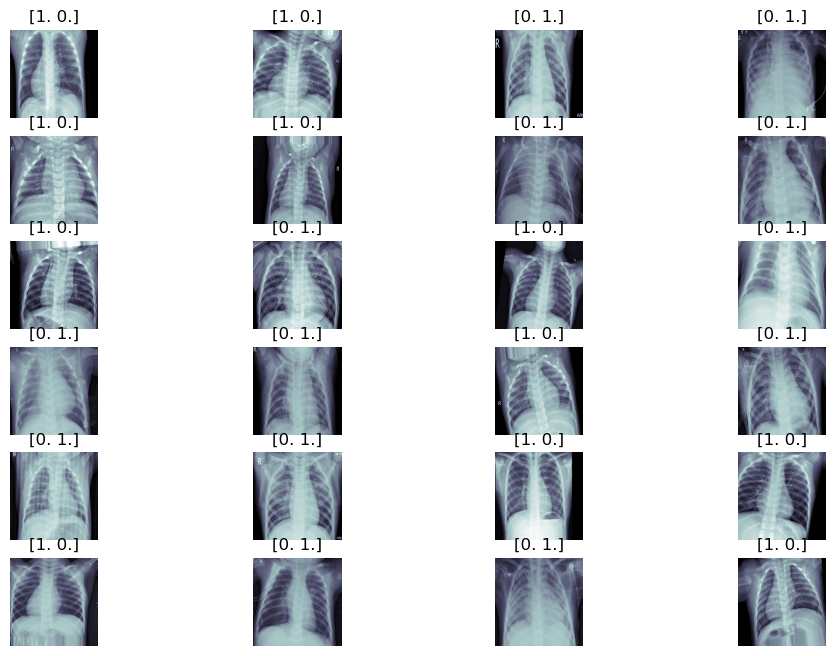

In [14]:
import matplotlib.pyplot as plt
fig, m_axs = plt.subplots(6, 4, figsize = (12, 8))
for (c_x, c_y, c_ax) in zip(x_test, y_test, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(str(c_y))
    c_ax.axis('off')

In [15]:
# config the session 
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(111)

tf.random.set_seed(111) #seeding for same type of output when run multiple times
from random import seed
seed(111)

# building the Cnn model

In [17]:
from keras import layers, Model, backend
channel_axis = -1
def model():
    img_input = layers.Input(shape = (224, 224, 3))
    # block 1
    x = layers.Conv2D(32, (3,3),padding = 'same', use_bias = False)(img_input)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2),strides=(2, 2),padding='same')(x)

    # block 2
    x = layers.Conv2D(64, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2),strides=(2, 2),padding='same')(x)

    # block 3
    x = layers.Conv2D(128, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3),strides=(3, 3),padding='same')(x)
    
    # block 4
    x = layers.Conv2D(256, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3),strides=(3, 3),padding='same')(x)

    # block 5
    x = layers.Conv2D(1024, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3,3),padding = 'same', use_bias = False)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization(axis = channel_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3),strides=(3, 3),padding='same')(x)
    
    x = layers.Flatten(name='flatten')(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(2, activation='softmax')(x)
    model = Model(inputs=img_input, outputs=x)
    return model
model = model()

In [18]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 128)    │             

 Total params: 10,604,578 (40.45 MB)

 Trainable params: 10,599,842 (40.44 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [19]:
LEARN_RATE = 1e-4
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = LEARN_RATE), loss = 'binary_crossentropy',metrics = ['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "save.best_weights.weights.h5"  

checkpoint = ModelCheckpoint(weight_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min',save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=5,verbose=1,mode='auto',
                                   min_delta=0.0001,cooldown=5,min_lr=0.0001)

early = EarlyStopping(monitor="val_loss",mode="min",patience=10)

cb = [checkpoint,early,reduceLROnPlat]

In [21]:
history = model.fit(x_train,y_train,batch_size = 32, 
                    epochs = 20, verbose=1,  validation_split=0.1, callbacks=cb)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8795 - loss: 0.2765
Epoch 1: val_loss improved from inf to 1.32011, saving model to save.best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.8798 - loss: 0.2758 - val_accuracy: 0.4591 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9691 - loss: 0.0877
Epoch 2: val_loss did not improve from 1.32011
169/169 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9691 - loss: 0.0876 - val_accuracy: 0.4608 - val_loss: 1.4775 - learning_rate: 1.0000e-04
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9806 - loss: 0.0512
Epoch 3: val_loss improved from 1.32011 to 0.35012, saving model to save.best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9806 -

In [24]:
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9789 - loss: 0.0853
Loss on test set:  0.08615127950906754
Accuracy on test set:  0.9793291687965393


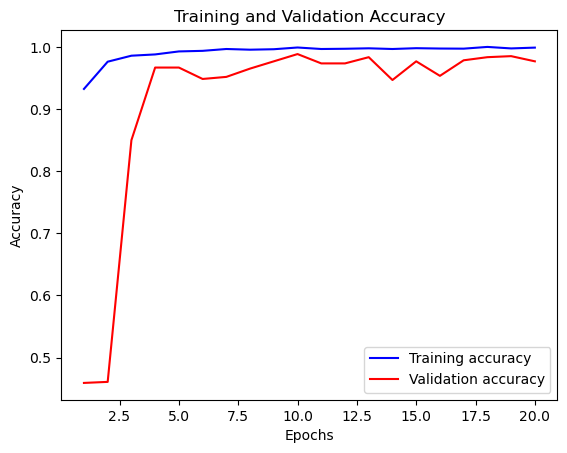

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

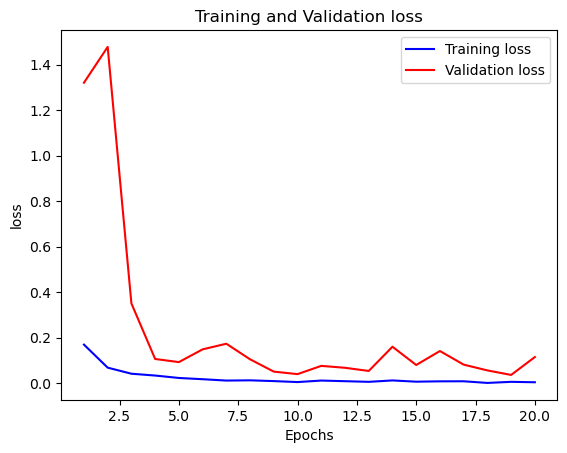

In [26]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()